# Proste klasyfikatory do predykcji

### Zmienne i wymagane biblioteki

In [1]:
import matplotlib.pyplot as plt # Wyświetlanie obrazów
import cv2 # Operacje na obrazach
import numpy as np # Operacje na macierzach
from sklearn.neighbors import KNeighborsClassifier # Klasyfikator KNN
from os import listdir # Wyświetlanie zawartości folderu
from random import randint, seed # Zapewnienie losowości
from tqdm.notebook import tqdm # Pasek postępu
import math # Funkcje matematyczne do normalizacji momentów Hu
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Macierz pomyłek
import math # Operacje matematyczne

%matplotlib inline

# Folder z obrazami do dodania do klasyfikatora
TRAIN_DIR = 'train/images'
# Folder z obrazami do testów klasyfikatora
TEST_DIR = 'test/images'
# Folder z maskami eksperckimi do treningu
TRAIN_MASKS_DIR = 'train/ground_truth'
# Folder z maskami eksperckimi do ewaluacji jakości klasyfikatora
TEST_MASKS_DIR = 'test/ground_truth'
# Rozmiar obrazu podczas działania algorytmu
img_size = (1024, 1024)
# Rozmiar fragmentu używanego do testów i treningu (musi być liczbą nieparzystą!)
sample_size = 5

### Wycinanie podobrazów

In [2]:
size = 5 # Rozmiar obrazu
x = 0
y = 0
# Przykładowy obraz...
example_img = np.eye(size)
print(example_img)
# rozszerzony o rozmiar podobrazu który ma zostać wycięty
expanded_img = np.pad(example_img, [(size // 2, size // 2), (size // 2, size // 2)], 'constant', constant_values=(0,0))
print(expanded_img)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [3]:
# Wypisz co znajduje się w pikselu na pozycji (x, y)
print(expanded_img[x + size // 2][y + size // 2])
# Zamień ten piksel na niepowtarzalną wartość dla lepszej wizualizacji (powinien być w centrum)
expanded_img[x + size // 2][y + size // 2] = 5
# Wypisz wycięty fragment
print(expanded_img[x:x+size, y:y+size])

1.0
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [4]:
def get_fragment(img, x, y, size):
    '''
    Wytnij podobraz tak, aby (x,y) było centralnym pikselem. Należy obraz rozszerzyć aby zapobiec wychodzeniu poza obraz.
    :param img: - obraz, z którego ma zostać wycięty podobraz
    :param x: - współrzędna OX środkowego piksela wycinka
    :param y: - współrzędna OY środkowego piksela wycinka
    :param size: - szerokość i wysokość wycinka
    '''
    expanded_image = np.pad(img, [(size // 2, size // 2), (size // 2, size // 2)], 'constant', constant_values=(0,0))
    return expanded_image[x:x+size, y:y+size]

### Funkcje pomocnicze

In [5]:
def join_tables(tables):
    '''
    Scalanie tablic. Przykładowo dla tablicy:
    [[0, 1, 2],
     [1, 3, 4]]
    Zwróci [0, 1, 2, 1, 3, 4].
    :param tables: - tablice do złączenia
    '''
    result = []
    for table in tables:
        result.extend(table)
    return result

In [6]:
def get_label(img, x, y):
    '''
    Wyciągnij predykcję z maski dla współrzędnych x i y. Jeżeli piksel jest biały, jest to żyła. W przeciwnym wypadku zwróć 0.
    :param img: - obraz maski
    :param x: - współrzędna OX badanego piksela
    :param y: - współrzędna OY badanego piksela
    '''
    return 1 if img[x][y] == 255 else 0

In [7]:
def get_moments(sample):
    '''
    Wyciągnij momenty Hu z podobrazka
    :param sample: - podobrazek (dowolnej wielkości)
    '''
    moments = cv2.moments(sample)
    huMoments = cv2.HuMoments(moments)
    for idx, moment in enumerate(huMoments):
        if moment[0] == 0:
            huMoments[idx][0] = 0
        else:
            huMoments[idx][0] = -1 * math.copysign(1.0, moment[0]) * math.log10(abs(moment[0]))
    return [ elem[0] for elem in huMoments ]

In [8]:
def get_hu_prediction(img, model):
    '''
    Uzyskaj predykcję dla podobrazka na podstawie jego momentów Hu.
    :param img: - podobrazek wejściowy
    :param model: - klasyfikator wykonujący predykcję
    '''
    moments = get_moments(img)
    return model.predict([moments])[0]

In [10]:
def get_merged_prediction(img, model):
    '''
    Uzyskaj predykcję dla scalonego modelu.
    :param img: - podobrazek wejściowy
    :param model: - klasyfikator wykonujący predykcję
    '''
    moments = get_moments(img)
    return model.predict([moments + join_tables(img)])[0]

In [12]:
def get_hu_samples(img, mask, sample_size, maxSamples = 200, guaranteedVeins = 50):
    '''
    Funkcja dzieląca obraz na podobrazki, a następnie wyliczająca ich momenty Hu, które będą wykorzystane do
    klasyfikacji. Następnie wyznaczane są oznaczenia zestawu danych (czy jest żyłą czy nie na podstawie maski).
    :param img: - obraz wejściowy
    :param mask: - maska ekspercka
    :param sample_size: - rozmiar podobrazów
    :param maxSamples: - maksymalna liczba próbek per obraz
    :param guaranteedVeins: - ile minimum próbek MUSI być żyłami
    '''
    result = [[], []]
    seed(42) # Zapewnienie losowości
    veinsSoFar = 0
    samples = 0
    
    while (samples < maxSamples):
        # Losowanie centralnego piksela
        x = randint(0, img.shape[0] - 1)
        y = randint(0, img.shape[1] - 1)
        # Wyciąganie oznaczenia
        label = get_label(mask, x, y)
        # Zapewnij, że liczba pozytywnych próbek wyniesie minimum guaranteedVeins
        if label == 1 and veinsSoFar < guaranteedVeins:
            veinsSoFar += 1
            # Dane do klasyfikatora
            fragment = get_fragment(img, x, y, sample_size)
            # Zapisz momenty Hu
            result[0].append(get_moments(fragment))
            # Zapisz predykcję
            result[1].append(label)
            samples += 1
        # Po spełnieniu wymogu minimalnych pozytywnych próbek, postępuj standardowo
        elif veinsSoFar >= guaranteedVeins:
            fragment = get_fragment(img, x, y, sample_size)
            # Zapisz momenty Hu
            result[0].append(get_moments(fragment))
            # Zapisz predykcję
            result[1].append(label)
            samples += 1

    return result

In [13]:
def get_merged_samples(img, mask, sample_size, maxSamples = 200, guaranteedVeins = 50):
    '''
    Funkcja dzieląca obraz na podobrazki, a następnie wyliczająca ich momenty Hu i piksele, które będą wykorzystane do
    klasyfikacji. Następnie wyznaczane są oznaczenia zestawu danych (czy jest żyłą czy nie na podstawie maski).
    :param img: - obraz wejściowy
    :param mask: - maska ekspercka
    :param sample_size: - rozmiar podobrazów
    :param maxSamples: - maksymalna liczba próbek per obraz
    :param guaranteedVeins: - ile minimum próbek MUSI być żyłami
    '''
    result = [[], []]
    seed(42) # Zapewnienie losowości
    veinsSoFar = 0
    samples = 0
    
    while (samples < maxSamples):
        # Losowanie centralnego piksela
        x = randint(0, img.shape[0] - 1)
        y = randint(0, img.shape[1] - 1)
        # Wyciąganie oznaczenia
        label = get_label(mask, x, y)
        # Zapewnij, że liczba pozytywnych próbek wyniesie minimum guaranteedVeins
        if label == 1 and veinsSoFar < guaranteedVeins:
            veinsSoFar += 1
            # Dane do klasyfikatora
            fragment = get_fragment(img, x, y, sample_size)
            # Zapisz momenty Hu i piksele podobrazu
            result[0].append(get_moments(fragment) + join_tables(fragment))
            # Zapisz predykcję
            result[1].append(label)
            samples += 1
        # Po spełnieniu wymogu minimalnych pozytywnych próbek, postępuj standardowo
        elif veinsSoFar >= guaranteedVeins:
            fragment = get_fragment(img, x, y, sample_size)
            # Zapisz momenty Hu i piksele podobrazu
            result[0].append(get_moments(fragment) + join_tables(fragment))
            # Zapisz predykcję
            result[1].append(label)
            samples += 1

    return result

### Trenowanie klasyfikatora KNN

In [14]:
def get_hu_model(fragment_size=sample_size, n_neighbors=10, truths=75):
    train_data = []
    train_labels = []
    data = []

    num_images = len(listdir(TRAIN_DIR))
    for image in tqdm(listdir(TRAIN_DIR)):
        # Wczytywanie obrazu
        img = cv2.imread(f'{TRAIN_DIR}/{image}', cv2.IMREAD_COLOR)
        # Zmniejsz rozmiar
        img = cv2.resize(img, img_size)
        # Wyciągnij kanał zielony (ma najlepszy kontrast żył do reszty obrazu)
        _, img, _ = cv2.split(img)
        # Wyrównaj histogram kolorów
        img = cv2.equalizeHist(img)

        # Wczytaj maskę
        mask = cv2.imread(f'{TRAIN_MASKS_DIR}/{image.split(".")[0] + ".tif"}', cv2.IMREAD_GRAYSCALE)
        # Zmniejsz rozmiar
        mask = cv2.resize(mask, img_size)

        # Wyciągnij dane dla klasyfikatora
        data = get_set_samples(img, mask, fragment_size, 200, truths)

        train_data += data[0]
        train_labels += data[1]

    # Oblicz ile wybranych podobrazów zakwalifikowało się jako żyła
    num = 0
    for label in train_labels:
        if label == 1:
            num += 1
    print(f"Liczba podobrazów żył: {num}")
    print(f"Liczba wszystkich podobrazów: {len(train_labels)}")

    # Stwórz klasyfikator KNN
    hu_model = KNeighborsClassifier(n_neighbors=10)
    # Uzupełnij go wydobytymi punktami
    hu_model.fit(train_data, train_labels)
    
    return hu_model

In [15]:
def get_merged_model(fragment_size=sample_size, n_neighbors=10, truths=75, num_samples=200, img_size = (1024, 1024)):
    train_data = []
    train_labels = []
    data = []

    num_images = len(listdir(TRAIN_DIR))
    for image in tqdm(listdir(TRAIN_DIR)):
        # Wczytywanie obrazu
        img = cv2.imread(f'{TRAIN_DIR}/{image}', cv2.IMREAD_COLOR)
        # Zmniejsz rozmiar
        img = cv2.resize(img, img_size)
        # Wyciągnij kanał zielony (ma najlepszy kontrast żył do reszty obrazu)
        _, img, _ = cv2.split(img)
        # Wyrównaj histogram kolorów
        img = cv2.equalizeHist(img)

        # Wczytaj maskę
        mask = cv2.imread(f'{TRAIN_MASKS_DIR}/{image.split(".")[0] + ".tif"}', cv2.IMREAD_GRAYSCALE)
        # Zmniejsz rozmiar
        mask = cv2.resize(mask, img_size)

        # Wyciągnij dane dla klasyfikatora
        data = get_merged_samples(img, mask, fragment_size, num_samples, truths)

        train_data += data[0]
        train_labels += data[1]

    # Oblicz ile wybranych podobrazów zakwalifikowało się jako żyła
    num = 0
    for label in train_labels:
        if label == 1:
            num += 1
    print(f"Liczba podobrazów żył: {num}")
    print(f"Liczba wszystkich podobrazów: {len(train_labels)}")

    # Stwórz klasyfikator KNN
    merged_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    # Uzupełnij go wydobytymi punktami
    merged_model.fit(train_data, train_labels)
    
    return merged_model

### Testowanie predykcji

**UWAGA** : Obrazy zostały zmniejszone do rozmiaru $1024\times1024$ w celu ograniczenia czasu oczekiwania na rezultat. W przypadku predykcji dla oryginalnego rozmiaru ($3504\times2336$) należy zwiększyć rozmiar podobrazu (`sample_size`). Pozostałe kroki pozostają bez zmian.

#### 1. Cecha : Momenty Hu

  0%|          | 0/30 [00:00<?, ?it/s]

Liczba podobrazów żył: 2521
Liczba wszystkich podobrazów: 6000


  0%|          | 0/1024 [00:00<?, ?it/s]

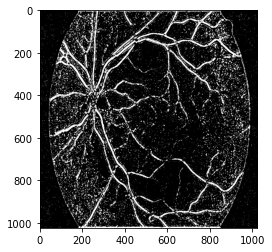

In [30]:
def get_hu_predictions(filepath, fragment_size=sample_size, n_neighbors=10, truths=75):
    # Wczytywanie obrazu
    img = cv2.imread(f'{TEST_DIR}/{filepath}', cv2.IMREAD_COLOR)
    # Zmniejszenie obrazu w celu skrócenia czasu trwania obliczeń
    #img = cv2.resize(img, img_size)
    # Ekstrakcja zielonego kanału z obrazu
    _, g_img, _ = cv2.split(img)
    # Balansowanie histogramu kolorów
    g_img = cv2.equalizeHist(img)
    result = np.zeros((img.shape[0], img.shape[1]))
    # Uczenie modelu
    model = get_hu_model(fragment_size, n_neighbors, truths)
    # Kalkulowanie obrazu na podsatwie predykcji
    for x, row in enumerate(tqdm(img)):
        for y, _ in enumerate(row):
            result[x][y] = get_hu_prediction(get_fragment(img, x, y, fragment_size), model)
    return result

filepath = listdir(TEST_DIR)[3]

hu_res = get_predictions(filepath, 15)
plt.imshow(hu_res, cmap='gray')

#### 2. Cecha : Momenty Hu + Piksele

In [16]:
def get_merged_predictions(filepath, fragment_size=sample_size, n_neighbors=10, truths=75, img_size = (1024, 1024)):
    # Wczytywanie obrazu
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)
    # Zmniejszenie obrazu w celu skrócenia czasu trwania obliczeń
    img = cv2.resize(img, img_size)
    # Ekstrakcja zielonego kanału z obrazu
    _, g_img, _ = cv2.split(img)
    # Balansowanie histogramu kolorów
    g_img = cv2.equalizeHist(g_img)
    result = np.zeros((g_img.shape[0], g_img.shape[1]))
    # Uczenie modelu
    model = get_merged_model(fragment_size, n_neighbors, 50, 100, (img.shape[0], img.shape[1]))
    # Kalkulowanie obrazu na podsatwie predykcji
    for x, row in enumerate(tqdm(g_img)):
        for y, _ in enumerate(row):
            result[x][y] = get_merged_prediction(get_fragment(g_img, x, y, fragment_size), model)
    return result

#filepath = f"{TEST_DIR}/{listdir(TEST_DIR)[0]}"

#res = get_merged_predictions(filepath, 15)
#plt.imshow(res, cmap='gray')

### Analiza statystyczna

**Funkcje do analizy są przekopiowane z notatnika z morfologią (na 3.0).**

In [17]:
def get_confusion_matrix(data):
    predictions, truth = data
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0
    print("Creating confusion matrix...")
    for idx, val in enumerate(tqdm(predictions)):
        if val == truth[idx]:
            if val == 1:
                true_positives += 1
            else:
                true_negatives += 1
        else:
            if val == 1:
                false_positives += 1
            else:
                false_negatives += 1

    confusion_matrix = np.matrix([
        [true_negatives, false_positives],
        [false_negatives, true_positives]
    ])
    return confusion_matrix

def get_analsyis_metrics(TP, TN, FP, FN):
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    # Sensitivity = TP / (TP + FN)
    sensitivity = TP / (TP + FN)
    # Specificity = TN / (TN + FP)
    specificity = TN / (TN + FP)
    # Balanced Accuracy = (Sensitivity + Specificity) / 2
    balanced_accuracy = (sensitivity + specificity) / 2
    # Geometric Accuracy = Sqrt(Sensitivity * Specificity)
    geometric_accuracy = math.sqrt(sensitivity * specificity)
    
    return [accuracy, sensitivity, specificity, balanced_accuracy, geometric_accuracy]

In [18]:
def get_statistics(img_path, mask_path):
    res = get_merged_predictions(img_path, 15)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size)
    data = [np.concatenate(res), np.concatenate(mask)]
    mat = get_confusion_matrix(data)
    disp = ConfusionMatrixDisplay(confusion_matrix=mat)
    metrics = get_analsyis_metrics(mat[1, 1], mat[0, 0], mat[0, 1], mat[1, 0])
    print(f"Trafność: {int(metrics[0] * 100)}%")
    print(f"Czułość: {int(metrics[1] * 100)}%")
    print(f"Swoistość: {int(metrics[2] * 100)}%")
    print(f"Zrównoważona trafność (średnia arytmetyczna): {int(metrics[3] * 100)}%")
    print(f"Zrównoważona trafność (średnia geometryczna): {int(metrics[4] * 100)}%")
    return [res, mask, disp]

In [21]:
images = [ f"{TEST_DIR}/{img}" for img in listdir(TEST_DIR) ]
masks = [ f"{TEST_MASKS_DIR}/{mask}" for mask in listdir(TEST_MASKS_DIR) ]

  0%|          | 0/30 [00:00<?, ?it/s]

Liczba podobrazów żył: 1592
Liczba wszystkich podobrazów: 3000


  0%|          | 0/1024 [00:00<?, ?it/s]

Creating confusion matrix...


  0%|          | 0/1048576 [00:00<?, ?it/s]

Trafność: 87%
Czułość: 0%
Swoistość: 91%
Zrównoważona trafność (średnia arytmetyczna): 45%
Zrównoważona trafność (średnia geometryczna): 3%


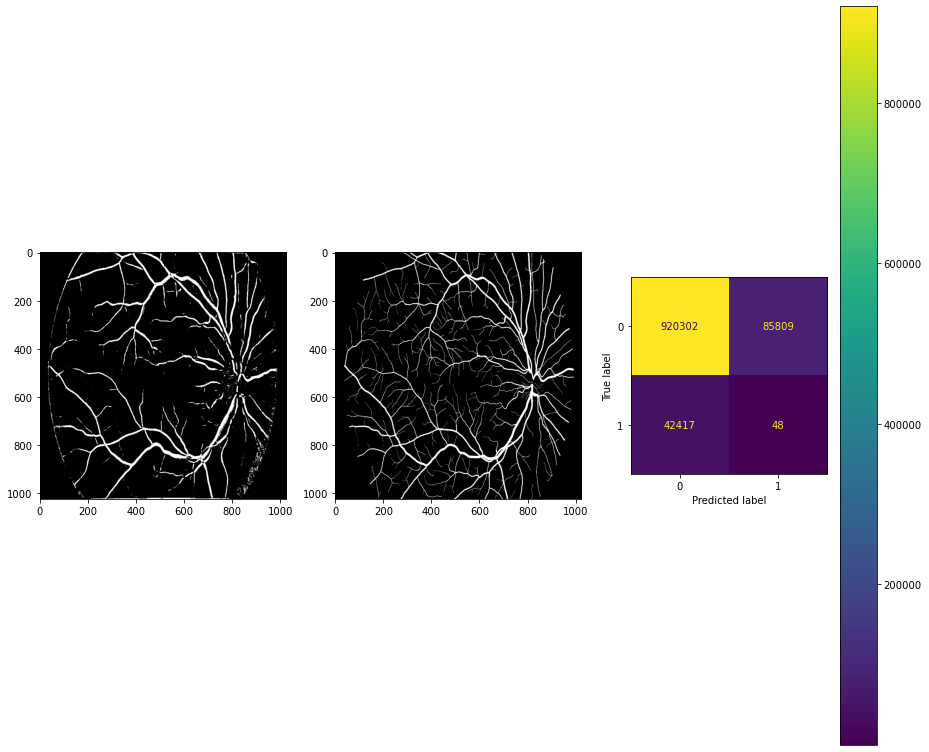

In [22]:
prediction, truth, matrix = get_statistics(images[0], masks[0])
fig, axs = plt.subplots(1,3, figsize=(15,15))
axs[0].imshow(prediction, cmap="gray")
axs[1].imshow(truth, cmap="gray")
matrix.plot(ax=axs[2])
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

Liczba podobrazów żył: 1592
Liczba wszystkich podobrazów: 3000


  0%|          | 0/1024 [00:00<?, ?it/s]

Creating confusion matrix...


  0%|          | 0/1048576 [00:00<?, ?it/s]

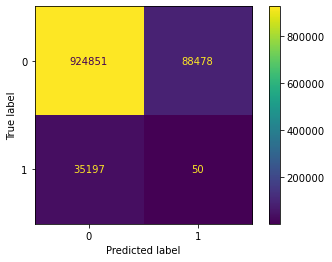

Trafność: 88%
Czułość: 0%
Swoistość: 91%
Zrównoważona trafność (średnia arytmetyczna): 45%
Zrównoważona trafność (średnia geometryczna): 3%


In [110]:
print_statistics(images[1], masks[1])

  0%|          | 0/30 [00:00<?, ?it/s]

Liczba podobrazów żył: 1592
Liczba wszystkich podobrazów: 3000


  0%|          | 0/1024 [00:00<?, ?it/s]

Creating confusion matrix...


  0%|          | 0/1048576 [00:00<?, ?it/s]

Trafność: 86%
Czułość: 0%
Swoistość: 89%
Zrównoważona trafność (średnia arytmetyczna): 44%
Zrównoważona trafność (średnia geometryczna): 3%


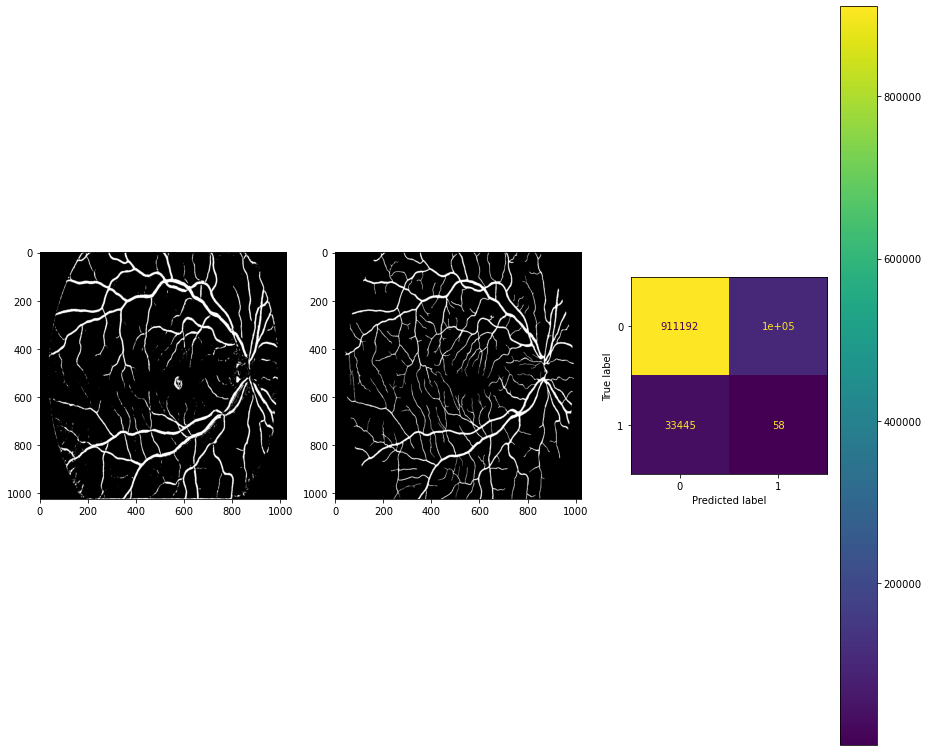

In [126]:
prediction, truth, matrix = get_statistics(images[2], masks[2])
fig, axs = plt.subplots(1,3, figsize=(15,15))
axs[0].imshow(prediction, cmap="gray")
axs[1].imshow(truth, cmap="gray")
matrix.plot(ax=axs[2])
plt.show()

In [ ]:
print_statistics(images[3], masks[3])

In [ ]:
print_statistics(images[4], masks[4])